## Facial recognition using different methods
* The Main purpose of this project is to basically try different approaches to solve the facial recognition problem and see what method works best to classify our model IU correctly
* Our approaches will focus on using Deep Learning as the main method but we will try different model structures and optimization algorithms to better solve our problem

## Data preparation
### images of people:
1. CelebA
2. Google Images
3. Videos

> The images in our dataset must all be aligned.
> Meaning that the faces need to be centered and cropped accordingly

> 2 Different datasets that both originate from the same dataset will be used to train our models
> For the models that implement triplet use, a MTCNN aligned dataset will be used, and all input will be MTCNN aligned.
> For the normal image classification networks, artificially augmented image data will be used as input.


### Input format:
128 X 128 RGB image

### Output format:
0~1 value 0 being not IU 1 being IU

## Locate faces in images

Using TensorFlow backend.


Processing: , Number of faces found: 1


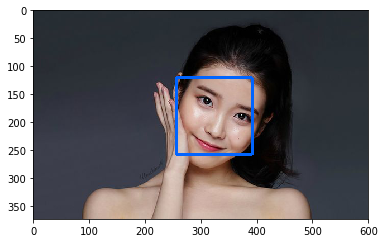

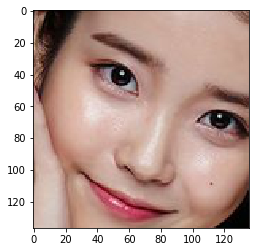

In [1]:
from data_prep.image_pipeline import ImageDisplayer, display_image_array
%matplotlib inline

ImageDisplayer("examples/2.jpg")

## Rotate align, and cut faces in images

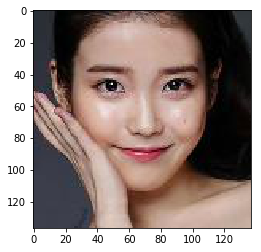

In [2]:
from PIL import Image
import numpy as np

aligned_image = Image.open("examples/output.jpg")
display_image_array(aligned_image)

## Augment images before feeding them in as input

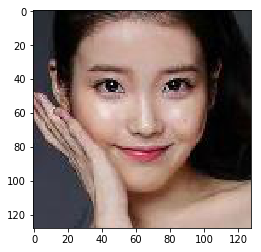

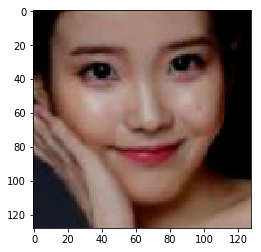

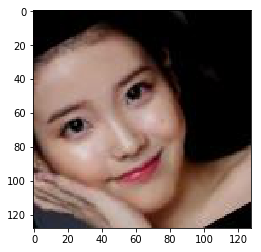

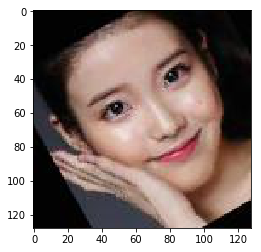

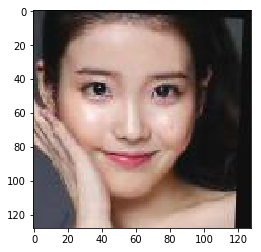

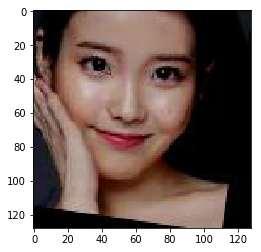

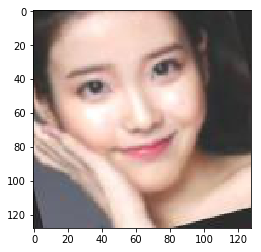

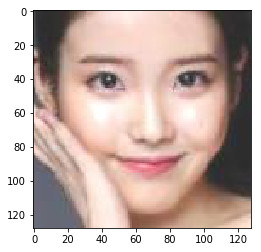

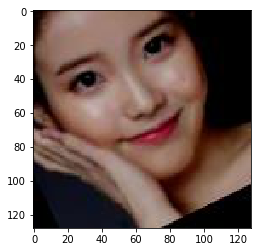

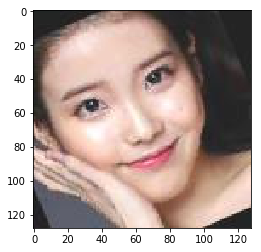

In [3]:
import os

augmented_path = os.path.join("examples", "augmented")
images = os.listdir(augmented_path)
for im in images:
    full_path = os.path.join(augmented_path, im)
    augmented_image = Image.open(full_path)
    display_image_array(augmented_image)

### Image pipeline summary
1. Get the original source image(Google images, videos and CelebA for negative samples)
2. Locate the face bounding boxes and landmarks
3. Filter out images that have too low quality
3. Rotate and scale to correctly align faces based on face landmarks
4. Make 9 different augmented versions of the image focused on augmenting, lighting, rotation, blur and scale (10 images in total per image including the original) **This step is meant to mimic real life photos**
5. Feed into network

**The augmented dataset is 10 times larger than the original filtered dataset.**  
**Images are resized to (128, 128) before being fed into network.**  
(Images of faces that do not fit the min image size are filtered out before)

In [ ]:
from test import test_model_individual
from cnn_models.hotdog import DeepDog
from cnn_models.cnn import CNN
from cnn_models.cnn_dropout import CNNDropout
from cnn_models.cnn_pool import CNNPool
from cnn_models.ensemble import Ensemble

model = Ensemble(summarize=False)
model.load_model()

test_model_individual(model, "examples/test/1.jpg")
test_model_individual(model, "examples/test/2.jpg")
test_model_individual(model, "examples/test/3.jpg")
test_model_individual(model, "examples/test/4.jpg")
test_model_individual(model, "examples/test/5.jpg")
test_model_individual(model, "examples/test/6.jpg")
test_model_individual(model, "examples/test/7.jpg")
test_model_individual(model, "examples/test/8.jpg")
test_model_individual(model, "examples/test/9.jpg")
test_model_individual(model, "examples/test/10.jpg")
test_model_individual(model, "examples/test/11.jpg")
test_model_individual(model, "examples/test/12.jpg")
test_model_individual(model, "examples/test/13.jpg")
test_model_individual(model, "examples/test/14.jpg")
test_model_individual(model, "examples/test/15.jpg")

Using TensorFlow backend.


# Currently using 4 different models

### 1. Separable Convolution (Inspired by Hotdog not Hotdog model)


In [5]:
from cnn_models.hotdog import DeepDog
model = DeepDog()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 128, 128, 3)       0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 64, 64, 32)        896       
_________________________________________________________________
batch_normalization_13 (Batc (None, 64, 64, 32)        128       
_________________________________________________________________
activation_13 (Activation)   (None, 64, 64, 32)        0         
_________________________________________________________________
separable_conv2d_12 (Separab (None, 64, 64, 32)        1344      
_________________________________________________________________
batch_normalization_14 (Batc (None, 64, 64, 32)        128       
_________________________________________________________________
activation_14 (Activation)   (None, 64, 64, 32)        0         
__________

### 2. Convolutional Neural Network

In [6]:
from cnn_models.cnn import CNN

model = CNN()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         (None, 128, 128, 3)       0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 64, 64, 32)        896       
_________________________________________________________________
batch_normalization_25 (Batc (None, 64, 64, 32)        128       
_________________________________________________________________
activation_25 (Activation)   (None, 64, 64, 32)        0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 64, 64, 64)        18496     
_________________________________________________________________
batch_normalization_26 (Batc (None, 64, 64, 64)        256       
_________________________________________________________________
activation_26 (Activation)   (None, 64, 64, 64)        0         
__________

### 3. Convolutional Neural Network - 2  
**CNN Model that uses Pooling layers in between**

In [7]:
from cnn_models.cnn_pool import CNNPool

model = CNNPool()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         (None, 128, 128, 3)       0         
_________________________________________________________________
conv2d_12 (Conv2D)           (None, 128, 128, 32)      896       
_________________________________________________________________
batch_normalization_34 (Batc (None, 128, 128, 32)      128       
_________________________________________________________________
activation_34 (Activation)   (None, 128, 128, 32)      0         
_________________________________________________________________
conv2d_13 (Conv2D)           (None, 128, 128, 64)      18496     
_________________________________________________________________
batch_normalization_35 (Batc (None, 128, 128, 64)      256       
_________________________________________________________________
activation_35 (Activation)   (None, 128, 128, 64)      0         
__________

### 4. Convolutional Neural Network - 3

**Convolutional Neural Network that uses Dropout to reduce overfitting and generalize better**

In [8]:
from cnn_models.cnn_dropout import CNNDropout

model = CNNDropout()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_5 (InputLayer)         (None, 128, 128, 3)       0         
_________________________________________________________________
conv2d_21 (Conv2D)           (None, 128, 128, 32)      896       
_________________________________________________________________
batch_normalization_43 (Batc (None, 128, 128, 32)      128       
_________________________________________________________________
activation_43 (Activation)   (None, 128, 128, 32)      0         
_________________________________________________________________
conv2d_22 (Conv2D)           (None, 128, 128, 64)      18496     
_________________________________________________________________
batch_normalization_44 (Batc (None, 128, 128, 64)      256       
_________________________________________________________________
activation_44 (Activation)   (None, 128, 128, 64)      0         
__________